In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import eli5
from eli5.sklearn import PermutationImportance

import tensorflow as tf
from tensorflow import keras


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import category_encoders as ce
import graphviz

In [270]:
def filter_years(df):
    """
    filters years 2013 and 2018 which we have to handle.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'].dt.year.isin([2013, 2018])]
    return df

weather = pd.read_csv("weatherAUS.csv")  # read csv data into pandas data frame
weather = filter_years(weather)
weather['Date'].dt.year.value_counts()

2018    17821
2013    16415
Name: Date, dtype: int64

# Aufgabe 1 Feature Engineering

In [271]:
# Spalten mit fehlender Zielvariable "RainTomorrow" rausschmeißen.
# Man könnte diese Auch als Testvariablen nehmen, dann wären diese aber nicht zufällig ausgewählt...
weather = weather[weather['RainTomorrow'].notna()]

In [272]:
# Spalten, in denen mehr als 40% der Variablen fehlen rausscheißen.
# Zeilen, in denen mehr als 50% der Variablen fehlen rausschmeißen.

weather = weather[weather.columns[weather.isnull().mean() < 0.4]]
weather = weather.loc[weather.isnull().mean(axis=1) < 0.5]

## Feate creation
creating new features

In [273]:
weather['Year'] = weather['Date'].dt.year  # get year
weather['Month'] = weather['Date'].dt.month  # get month
weather['Day'] = weather['Date'].dt.day  # get day

weather['MinMaxDiff'] = weather['MaxTemp'] - weather['MinTemp']
weather['PressureDiff'] = weather['Pressure3pm'] - weather['Pressure9am']
weather['WindSpeedDiff'] = weather['Pressure3pm'] - weather['WindSpeed9am']
weather['HumidityDiff'] = weather['Humidity3pm'] - weather['Humidity9am']

## Feature Binning

diskretisierung von Features. 

In [274]:
def encode_season(month):
    if month >= 9 and month <= 11:
        return 'Spring'
    if month == 12 or month <= 2:
        return 'Summer'
    if month >= 3 and month <= 5:
        return 'Autumn'
    if month >= 6 and month <= 8:
        return 'Winter'
    
weather['Season'] = weather['Month'].apply(encode_season)


In [275]:
# Ist quasy "Target Encoding". Nur halt manuell...

def encode_rainly_month(month):
    rainy_month = [5,6, 7,8,11]
    if month in rainy_month:
        return 1
    return 0

weather['RainyMonth'] = weather['Month'].apply(encode_rainly_month)

## Train Test split
**Important!** 

Before starting Feature Engineering one must split the dataset to ovoid test train leakage!
All Decisions in Data Engineering must be made on the Train Set only! From here, we assume that we dont have any 
knowledge about the test data.

In [276]:
#Zunächst wird noch nicht die Zielvariable "abgespalten"
#Warum? Wenn die Zielvariable noch im gleichen DataFrame ist, kann man leichter Outlier rausschmeißen.
train, test = train_test_split(weather, test_size=0.2, random_state = 0)

## Outlier detection (Optional)
**important**

this must be done after splitting. Again: We do not know anything about the test data!

**-> Verschlechtert das Ergebnis!**

Text(0, 0.5, 'WindGustSpeed')

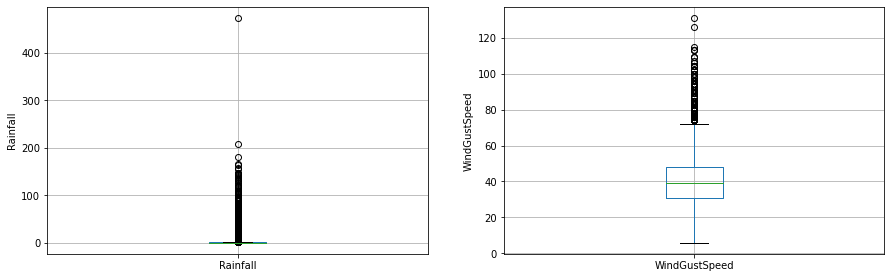

In [267]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = train.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')

plt.subplot(2, 2, 2)
fig = train.boxplot(column='WindGustSpeed')
fig.set_title('')
fig.set_ylabel('WindGustSpeed')

In [268]:
higher_lim = train['Rainfall'].quantile(0.995)
train = train[train['Rainfall'] < higher_lim]
higher_lim = train['WindGustSpeed'].quantile(0.995)
train = train[train['WindGustSpeed'] < higher_lim]

## Train Test Split part 2

hier wird jetzt die Zielvariable abgespalten

In [277]:
X_train = train.drop(['RainTomorrow'], axis=1)
y_train = train['RainTomorrow']

X_test = test.drop(['RainTomorrow'], axis=1)
y_test = test['RainTomorrow']

## Impute missing Data (Univariat)

In [278]:
# Impute values the naiive approache without considering the locations or other stuff like season

for dataset in [X_train, X_test]:

    colums_containing_nan = dataset.columns[dataset.isnull().any()]
    
    numerical_containing_nan = [col for col in colums_containing_nan if dataset[col].dtypes != 'O']
    categorial_containing_nan = [col for col in colums_containing_nan if dataset[col].dtypes == 'O']

    for col in numerical_containing_nan:
        col_median=X_train[col].median() #always use median from Train data ! Never impute based on Test Data ! we have to assume we dont know it.
        dataset[col] = dataset[col].fillna(col_median) 
        
    for col in categorial_containing_nan:
        col_most_occuring = X_train[col].mode()[0]
        dataset[col] = dataset[col].fillna(col_most_occuring)     
        

# Encoding Categorial Variables

In [279]:
X_train['RainToday'] = X_train["RainToday"].replace({'No':0, 'Yes':1})
X_test['RainToday'] = X_test["RainToday"].replace({'No':0, 'Yes':1})

y_train = y_train.replace({'No':0, 'Yes':1})
y_test = y_test.replace({'No':0, 'Yes':1})

### Target encoding

Beim target Encoding kodieren wir die Variable als Einfluss auf die Zielvariable. Wenn es also in Perth zu 20% geregnet hat, dann wird Perth mit 0.2 kodiert.

In [280]:
# Create the encoder
cat_features=['Location','WindGustDir',"WindDir9am", "WindDir3pm"]
for feature in [cat_features]:
    target_enc = ce.TargetEncoder(cols=feature)
    target_enc.fit(X_train[feature], y_train)

    # Transform the features, rename the columns with _target suffix, and join to dataframe
    X_train = X_train.join(target_enc.transform(X_train[feature]).add_suffix('_target'))
    X_test = X_test.join(target_enc.transform(X_test[feature]).add_suffix('_target'))

### One Hot Encoding

In [281]:
# apply One Hot encoding

for col in ["Season"]:
    encoded_columns = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
    X_train = X_train.join(encoded_columns).drop(col, axis=1)
    
    encoded_columns = pd.get_dummies(X_test[col], prefix=col, drop_first=True)
    X_test = X_test.join(encoded_columns).drop(col, axis=1)

# Remove Features

Some features where transformed to other columns and can be removed.

In [282]:
columns_to_drop = ['Date', 'Location','WindGustDir',"WindDir9am", "WindDir3pm"]
X_train.drop(labels=columns_to_drop, axis=1, inplace=True)
X_test.drop(labels=columns_to_drop, axis=1, inplace=True)

## Scale numerical features

**Note !**
This step is not required for decision trees. Still it is recommended to do. Why?
1. We need it for Feature Selection 
2. If we change the tree to a regression or a NN, we need it.
3. It doesnt do any harm.

In [283]:
scaler = MinMaxScaler()
cols = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(np.array(X_test), columns=cols)

# Feature Selection


## The univariate way

In [ ]:
# Tamara
# show correlation matrix
train = X_train
train["RainTomorrow"] = y_train.values
train.corr()

In [ ]:
# Tamara
# show correlation matrix as heatmap
plt.imshow(train.corr(), cmap='hot', interpolation='nearest')
plt.show()

In [289]:
NUM_FEATURES_TO_SELECT = 5

selector = SelectKBest(f_classif, k=NUM_FEATURES_TO_SELECT)

X_new = selector.fit_transform(X_train, y_train)

selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=X_train.index, 
                                 columns=X_train.columns)

selected_columns = selected_features.columns[selected_features.var() != 0]

X_train[selected_columns].head()

,WindGustSpeed,Humidity9am,Humidity3pm,RainToday,MinMaxDiff
0,0.296,0.64,0.46,0.0,0.325733
1,0.384,0.55,0.27,1.0,0.472313
2,0.088,0.83,0.44,0.0,0.563518
3,0.232,0.47,0.22,0.0,0.530945
4,0.616,0.74,0.34,0.0,0.488599


## The multivariate way

In [27]:
# Regularisation strengh is set by regularization parameter C.
# Note: the lower C, the higher the regularization
logistic = LogisticRegression(C=0.01, penalty="l1", solver='liblinear', max_iter=10000, random_state=7).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X_train.index,
                                 columns=X_train.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]
selected_columns

Index(['WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'RainToday',
       'MinMaxDiff', 'WindSpeedDiff', 'RainyMonth', 'WindDir3pm_target',
       'Season_Summer'],
      dtype='object')

In [28]:
# getting accuracy for a logistic regression model 
logistic = LogisticRegression().fit(X_train[selected_columns], y_train)

test_predictions = logistic.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

0.8499250374812594


/Users/tobi/venv/kaggle/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.15007496251874064

# Aufgabe 2 Entscheidungsbäume

In [290]:
model = tree.DecisionTreeClassifier()

model.fit(X_train[selected_columns], y_train)

DecisionTreeClassifier()

In [292]:
test_predictions = model.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

0.9994752033586985


0.0005247966413014956

## Baseline

this is what we got from the beginnnig:
    
0.8435955056179776

0.15640449438202247

# Visualization

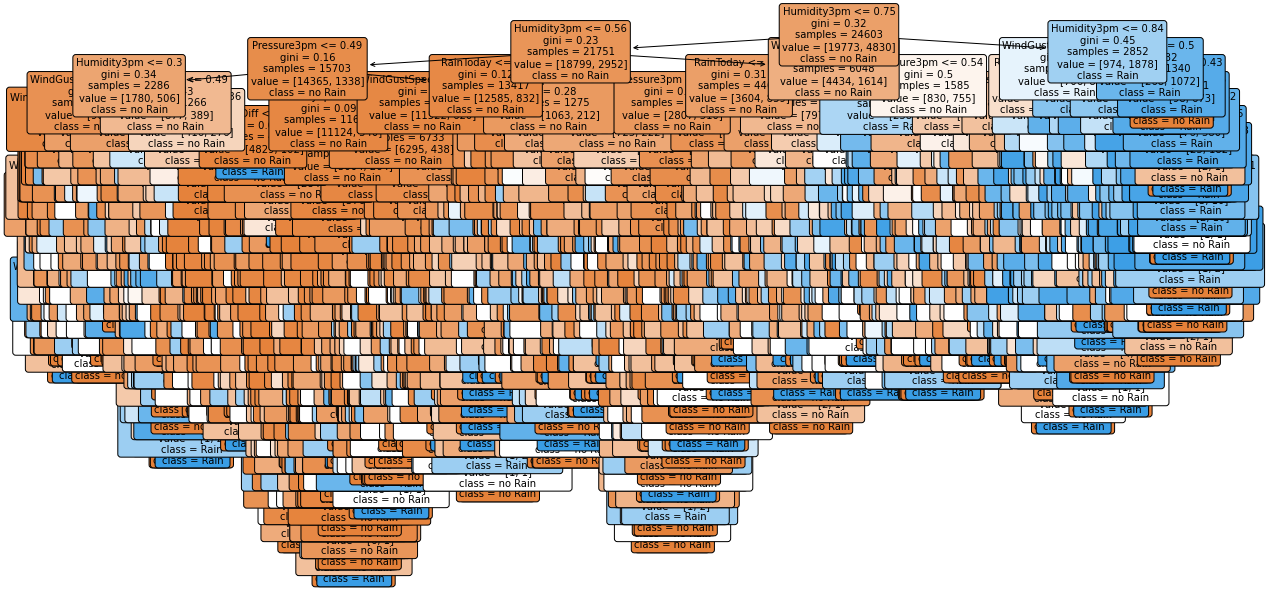

In [124]:
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model, ax=ax,
              feature_names=selected_columns,
              filled = True,
              rounded = True,
              precision =2,
              fontsize = 10,
               class_names=["no Rain", "Rain"]
              );

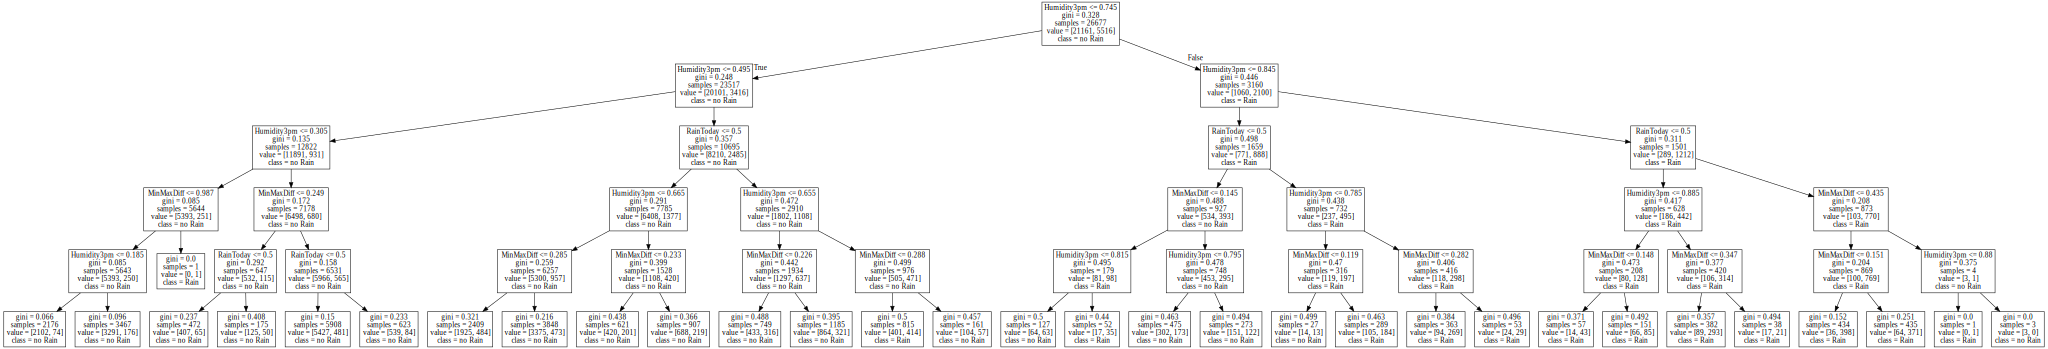

In [45]:
tree_graph = tree.export_graphviz(model, out_file=None, feature_names=selected_columns, class_names=["no Rain", "Rain"])
graphviz.Source(tree_graph)

In [298]:
# Tamara
# change max_depth
model1 = tree.DecisionTreeClassifier(max_depth=5)

model1.fit(X_train[selected_columns], y_train)

DecisionTreeClassifier(max_depth=5)

In [299]:
# Tamara
test_predictions1 = model1.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions1))
mean_absolute_error(y_test, test_predictions1)

0.844527736131934


0.15547226386806598

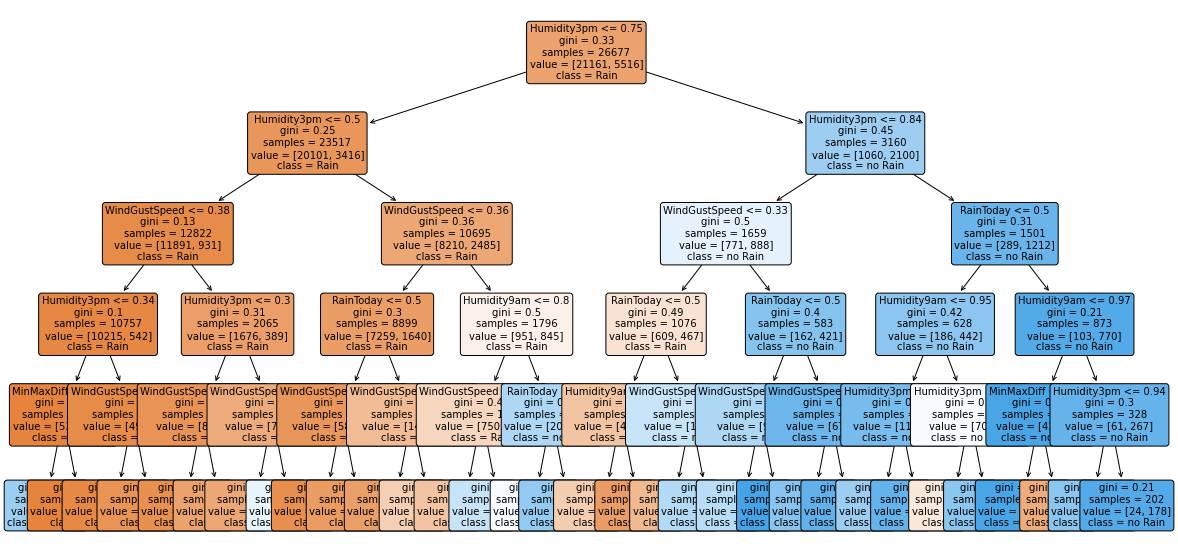

In [300]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model1, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

In [169]:
# Tamara
# change min_impurity_increase
model2 = tree.DecisionTreeClassifier(min_impurity_decrease=0.003)

model2.fit(X_train[selected_columns], y_train)

# Tamara
test_predictions2 = model2.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions2))
mean_absolute_error(y_test, test_predictions2)

0.8316341829085457


0.16836581709145426

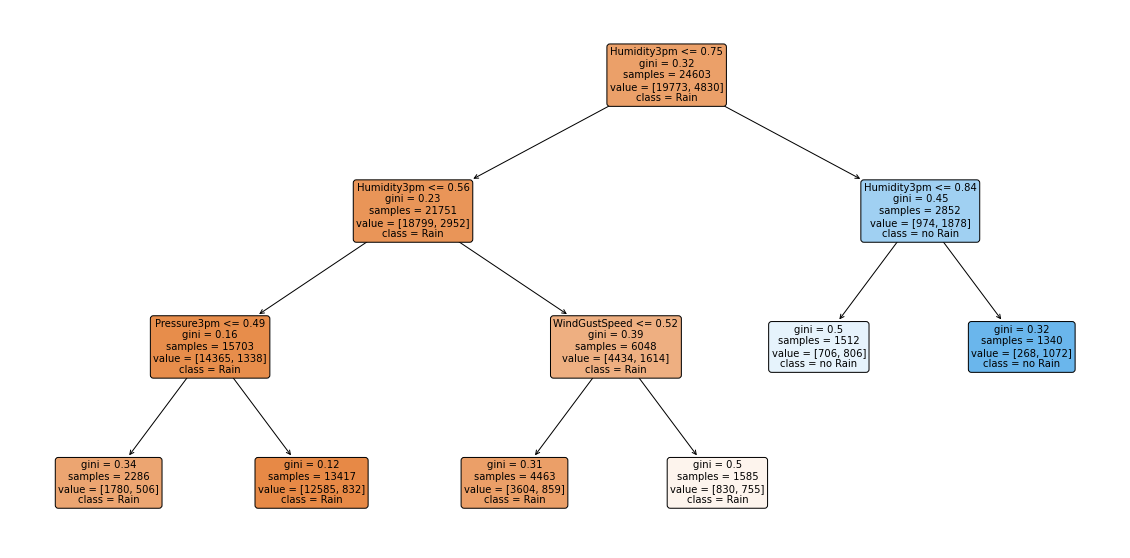

In [170]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model2, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

In [301]:
# Tamara
# change max_leaf_nodes
model3 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

model3.fit(X_train[selected_columns], y_train)

# Tamara
test_predictions3 = model3.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions3))
mean_absolute_error(y_test, test_predictions3)

0.8443778110944528


0.15562218890554722

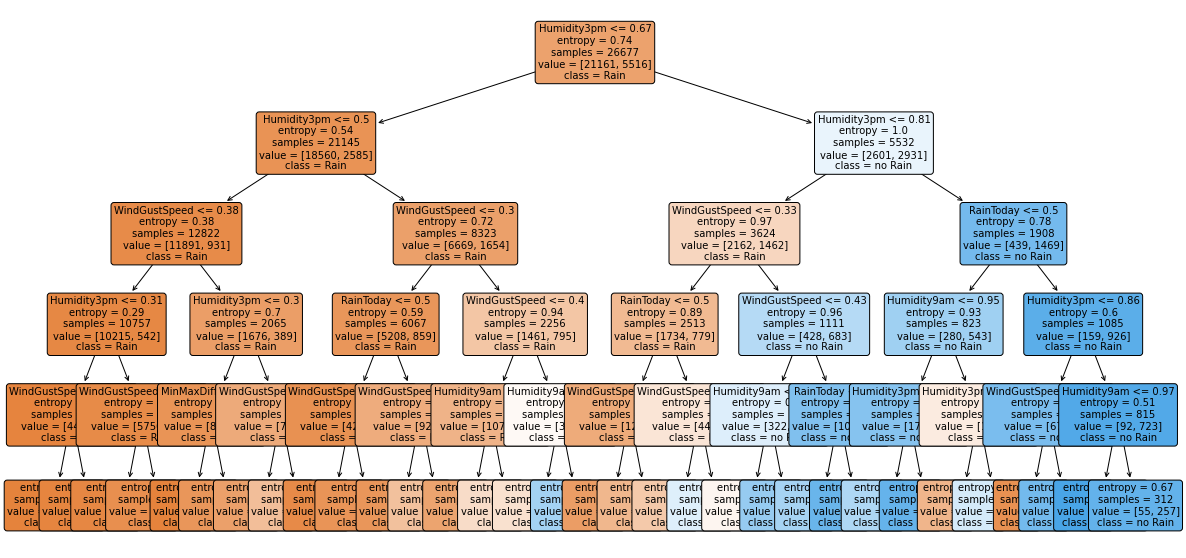

In [302]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model3, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

## Null accuracy 
Whats the accuracy of a model, which just predicts the most common class.

In [125]:
y_test.value_counts()

0    5318
1    1352
Name: RainTomorrow, dtype: int64

In [126]:
print(5272/(5272+1403))

0.789812734082397


## Analysis

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

# Booklet 2 Neuronale Netze Aufgabe 2

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_dataset = train_dataset.shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_dataset = test_dataset.shuffle(len(X_test)).batch(len(X_test))

In [ ]:
nn = tf.keras.Sequential([
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
nn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
nn.fit(train_dataset, 
       validation_steps=1,
       validation_data=test_dataset,
       epochs=10)